### Dream3

In [1]:
import sys
sys.path.append("../../") # if running from this folder
import torch
from matplotlib import pyplot as plt
import pandas as pd
import numpy as np
from src.models import NAVAR, TAMCaD
from src.data import load_dataset
from src.training import train_model, train_test_split
from src.eval import plot_contemporaneous_relationships, plot_all_contemporaneous_relationships, plot_heatmaps, AUROC
from tqdm.notebook import trange, tqdm
from IPython.display import Image, display
from lingam.utils import make_dot

In [56]:
dataset = load_dataset('dream3', 'yeast1')[0]
#dataset['ground_truth'] = dataset['ground_truth'].t()
print({k: v.shape if isinstance(v, torch.Tensor) else v for k, v in dataset.items()})

model_variations = {
    'TAMCaD': {'model_type': TAMCaD, 'gamma': 0.0, 'use_gumbel': True, 'n_blocks': 2, 'n_layers': 2, 'kernel_size': 2, 'lr': 4e-4, 'dropout': 0.1, 'weight_sharing':True, 'hidden_dim': 16},
    'NAVAR': {'model_type': NAVAR, 'lambda1': 0.3, 'n_blocks': 1, 'n_layers': 2, 'kernel_size': 3, 'lr': 5e-4, 'dropout': 0.2, 'hidden_dim': 32, },
}
params = {
    'experiment_name': 'dream3',
    'weight_decay': 1e-8,
    'test_size': 0.0,
    'epochs': 500
}

{'name': 'yeast1', 'data': torch.Size([46, 100, 21]), 'ground_truth': torch.Size([100, 100])}


In [57]:
all_results = {}

for id, model_params in model_variations.items():
    print('Process', id)
    all_results[id] = []
    for _ in range(1):
        all_results[id].append(train_model(
            experiment_run=id,
            dataset=dataset,
            **model_params,
            **params
        ))

Process TAMCaD


[train] loss=0.43,AUROC=0.53: 100%|██████████████████████████████████████████████████| 500/500 [00:44<00:00, 11.25it/s]


Process NAVAR


[train] loss=0.20,AUROC=0.54: 100%|██████████████████████████████████████████████████| 500/500 [00:52<00:00,  9.53it/s]


In [63]:
# Initialize the arrays to store the data
M = len(all_results)  # Number of models
N = len(next(iter(all_results.values())))  # Assuming all models have the same number of runs
T = len(next(iter(next(iter(all_results.values()))))['train_metrics']['loss'][1])  # Number of timesteps

losses = np.zeros((M, N, T))
training_times = np.zeros((M, N, T))
aurocs = np.zeros((M, N, T))
best_aurocs = np.zeros((M, N))
combined_matrix = []

# Iterate through each model's results
model_names = []
for i, (model_name, results_list) in enumerate(all_results.items()):
    model_names.append(model_name)
    for j, result in enumerate(results_list):
        losses[i, j, :] = result['train_metrics']['loss'][1].numpy()
        training_times[i, j, :] = np.full(T, 1000 * result['model_params']['training_time_per_epoch'])
        aurocs[i, j, :] = result['train_metrics']['AUROC'][1].numpy()
        best_aurocs[i, j] = result['train_metrics']['AUROC'][1].max().item()
        combined_matrix.append(result['train_artifacts']['matrix'])
combined_matrix = torch.stack(combined_matrix).mean(dim=0)

# Compute averages and standard deviations
avg_losses = np.mean(losses, axis=1)
avg_training_times = np.mean(training_times, axis=1)
avg_aurocs = np.mean(aurocs, axis=1)
avg_best_aurocs = np.mean(best_aurocs, axis=1)


std_losses = np.std(losses, axis=1)
std_aurocs = np.std(aurocs, axis=1)

# Create the table
table_data = {
    "Model": model_names,
    "AUROC (avg)": avg_best_aurocs,
    "Loss (avg)": np.mean(avg_losses, axis=1),
    "Time per Epoch (ms) (avg)": np.mean(avg_training_times, axis=1)
}
results_df = pd.DataFrame(table_data)
results_df.set_index("Model", inplace=True)
results_df.loc['Combined'] = [AUROC(dataset['ground_truth'], combined_matrix)[0].item(), -1, -1]
AUROC(dataset['ground_truth'], combined_matrix)[0].item()

results_df.sort_values('AUROC (avg)', ascending=False, inplace=True)
results_df

,AUROC (avg),Loss (avg),Time per Epoch (ms) (avg)
Model,,,
Combined,0.551263,-1.000000,-1.000000
TAMCaD,0.550535,0.454586,89.227311
NAVAR,0.548817,0.342253,105.389363


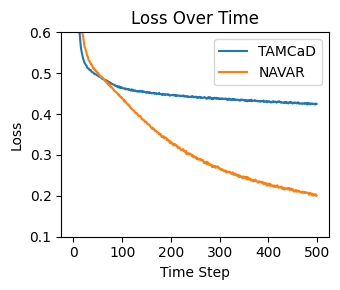

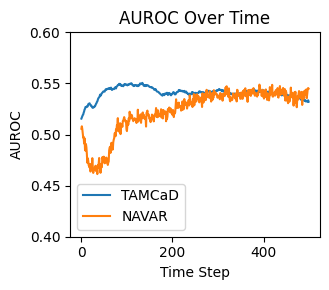

In [64]:
# Time steps for plotting
time_steps = np.arange(T)

# Plotting Loss for all models
plt.figure(figsize=(3.5,3))
for i, model_name in enumerate(model_names):
    plt.plot(time_steps, avg_losses[i], label=f'{model_name}')
    plt.fill_between(time_steps, avg_losses[i] - 2*std_losses[i], avg_losses[i] + 2*std_losses[i], alpha=0.2)

plt.title('Loss Over Time')
plt.xlabel('Time Step')
plt.ylabel('Loss')
plt.ylim(0.1, 0.6)  # Setting the y-axis limit for loss
plt.legend()
plt.tight_layout()
plt.savefig('noise_loss_plot.png', dpi=200)
plt.show()

# Plotting AUROC for all models
plt.figure(figsize=(3.5,3))
for i, model_name in enumerate(model_names):
    plt.plot(time_steps, avg_aurocs[i], label=f'{model_name}')
    plt.fill_between(time_steps, avg_aurocs[i] - 2*std_aurocs[i], avg_aurocs[i] + 2*std_aurocs[i], alpha=0.2)

plt.title('AUROC Over Time')
plt.xlabel('Time Step')
plt.ylabel('AUROC')
plt.ylim(0.4, 0.6)  # Setting the y-axis limit for AUROC
plt.legend()
plt.tight_layout()
plt.savefig('auroc_plot.png', dpi=200)
plt.show()


In [65]:
matrices = []
for i, (model_name, results_list) in enumerate(all_results.items()):
    matrices.append(torch.stack([results_list[i]['train_artifacts']['matrix'] for i in range(1)]).mean(dim=0))
matrices = torch.stack(matrices)
matrices.shape

torch.Size([2, 100, 100])

In [66]:
attn_logits = all_results['TAMCaD'][0]['train_artifacts']['attention_logits'].mean(dim=(0, -1))
print(attn_logits.shape)
tau = 0.1
attn_softmax = torch.softmax(attn_logits / tau, dim=-1)
attn_softmax.shape

torch.Size([100, 100])


torch.Size([100, 100])

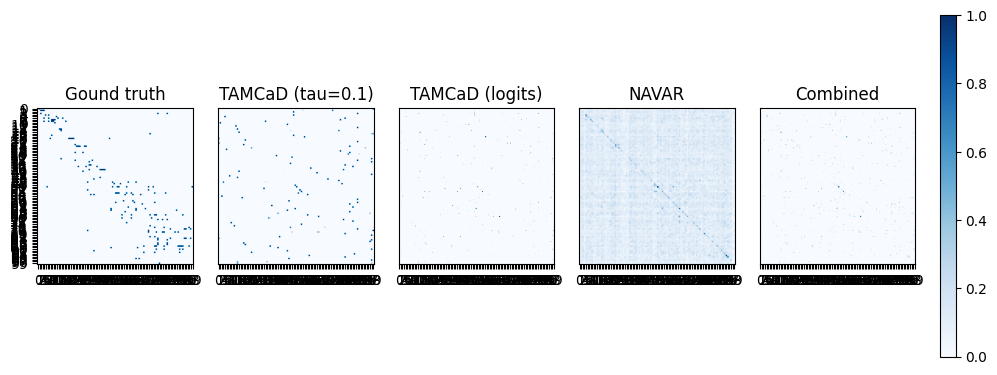

In [67]:
plot_heatmaps(dataset['ground_truth'], attn_softmax, *matrices, combined_matrix, names=['Gound truth', f'TAMCaD (tau={tau})', 'TAMCaD (logits)', 'NAVAR', 'Combined'] )
fig = plt.gcf()
fig.set_size_inches(10, 4, forward=True)
plt.savefig('heatmap.png', dpi=300)
plt.show()

In [9]:
#def render_graph(file_name, matrix):
#    dot_graph = make_dot(matrix, labels=[f"N{i}" for i in range(100)])
#    dot_graph.format = 'png'
#    dot_graph.render(file_name, cleanup=True)
#    display(Image(f'{file_name}.png'))

In [10]:
#render_graph('test', attn_softmax)